#### 19.07.09
- アミノ酸の3次元座標の取得
- その距離行列の計算

In [293]:
'''
pdbファイルの詳しい構成についての参考: 
    ftp://ftp.wwpdb.org/pub/pdb/doc/format_descriptions/Format_v33_A4.pdf 
    
取ってきたGFP
    http://www.rcsb.org/structure/1EMA 

Biopython参考 
    https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ 
'''

'\npdbファイルの詳しい構成についての参考: \n    ftp://ftp.wwpdb.org/pub/pdb/doc/format_descriptions/Format_v33_A4.pdf \n    \n取ってきたGFP\n    http://www.rcsb.org/structure/1EMA \n\nBiopython参考 \n    https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ \n'

In [386]:
# coding: UTF-8
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# sns.set_style('whitegrid')

import math
from Bio.PDB import *
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from matplotlib.colors import LinearSegmentedColormap
import mpl_toolkits.mplot3d.axes3d as axes3d

In [380]:
def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

cmap = generate_cmap(["black", '#03A9F4', "orange", "red"])
cmap2 = generate_cmap(["black", '#03A9F4', "orange", "red"][::-1])

### .pdbファイルから取得する
- pdb_parser.get_structureで取得すると, 完全な配列を取得できなかった
- → 生データから該当箇所を抽出

In [315]:
file_dir = '/home/lab/igarashi/Downloads/'

sequence = []
atom_coordinate = []

n_ca = 0

ca_coordinate = np.zeros((seq_length, 4))
ca_coordinate[:, 0] = np.arange(1, seq_length+1)

with open(f'{file_dir}/1ema.pdb', 'r') as f:
    # .pdbの中身生データ
    content = f.readlines()
    # print(content)
    
    for line in content:
        ### アミノ酸配列の取得 ###
        if line[:6]=='SEQRES':
            line_split = line.split(' ')
            line_split = [s for s in line_split if (s != '' and s!='\n')]
            seq_length = int(line_split[3])
            sequence.extend(line_split[4:])
            
            
        ### CA原子の取得 ###
        if line[:4]=='ATOM' or line[:6]=='HETATM':
            line_split = line.split(' ')
            line_split = [s for s in line_split if (s != '' and s!='\n')]
            
            atom_coordinate.append(line_split[1:])
            
            # CAもしくはCA1だけ
            if line_split[2]=='CA' or line_split[2]=='CA1':
                ca_coordinate[int(line_split[5])-1, 1:4] = line_split[6:9]
                n_ca += 1
            
            # 座標が存在しないアミノ酸の座標はNoneとする
            ca_coordinate[np.where(np.all(ca_coordinate[:, 1:4]==0, axis=1))[0], 1:4] = [None, None, None]
            
                
            # CA2なども
            # if line_split[2]=='CA' or line_split[2] in [f'CA{i}' for i in range(1, 11)]:
            

In [316]:
# アミノ酸表記を3文字 → 1文字に

AMINO_pair = {'ALA':'A', 'ASX':'B', 'CYS':'C', 'ASP':'D', 'GLU':'E', 'PHE':'F', 'GLY':'G', 'HIS':'H', 'ILE':'I', 'LYS':'K', 'LEU':'L', 'MSE':'M', 
              'ASN':'N', 'PRO':'P', 'GLN':'Q', 'ARG':'R', 'SER':'S', 'THR':'T', 'SEC':'U', 'VAL':'V', 'TRP':'W', 'CRO':'X', 'TYR':'Y', 'GLX':'Z'}
              
              # ASX, MSE, SEC, CRO, GLXは他の3文字表記があるかもしれない, http://nomenclator.la.coocan.jp/chem/text/aminosym.htmを参考にした

sequence_short = []

for amino in sequence:
    item_mod = amino.replace(amino, AMINO_pair[amino])
    
    #リストに追加
    sequence_short.append(item_mod)

In [338]:
print(len(sequence), sequence)
print(len(sequence_short), sequence_short)

236 ['MSE', 'SER', 'LYS', 'GLY', 'GLU', 'GLU', 'LEU', 'PHE', 'THR', 'GLY', 'VAL', 'VAL', 'PRO', 'ILE', 'LEU', 'VAL', 'GLU', 'LEU', 'ASP', 'GLY', 'ASP', 'VAL', 'ASN', 'GLY', 'HIS', 'LYS', 'PHE', 'SER', 'VAL', 'SER', 'GLY', 'GLU', 'GLY', 'GLU', 'GLY', 'ASP', 'ALA', 'THR', 'TYR', 'GLY', 'LYS', 'LEU', 'THR', 'LEU', 'LYS', 'PHE', 'ILE', 'CYS', 'THR', 'THR', 'GLY', 'LYS', 'LEU', 'PRO', 'VAL', 'PRO', 'TRP', 'PRO', 'THR', 'LEU', 'VAL', 'THR', 'THR', 'PHE', 'CRO', 'VAL', 'GLN', 'CYS', 'PHE', 'SER', 'ARG', 'TYR', 'PRO', 'ASP', 'HIS', 'MSE', 'LYS', 'ARG', 'HIS', 'ASP', 'PHE', 'PHE', 'LYS', 'SER', 'ALA', 'MSE', 'PRO', 'GLU', 'GLY', 'TYR', 'VAL', 'GLN', 'GLU', 'ARG', 'THR', 'ILE', 'PHE', 'PHE', 'LYS', 'ASP', 'ASP', 'GLY', 'ASN', 'TYR', 'LYS', 'THR', 'ARG', 'ALA', 'GLU', 'VAL', 'LYS', 'PHE', 'GLU', 'GLY', 'ASP', 'THR', 'LEU', 'VAL', 'ASN', 'ARG', 'ILE', 'GLU', 'LEU', 'LYS', 'GLY', 'ILE', 'ASP', 'PHE', 'LYS', 'GLU', 'ASP', 'GLY', 'ASN', 'ILE', 'LEU', 'GLY', 'HIS', 'LYS', 'LEU', 'GLU', 'TYR', 'ASN', '

In [339]:
pd.DataFrame(ca_coordinate)

,0,1,2,3
0,1.0,NaN,NaN,NaN
1,2.0,27.638,10.125,52.516
2,3.0,24.141,10.191,51.036
3,4.0,24.297,11.798,47.605
4,5.0,27.821,10.598,46.726
5,6.0,26.479,7.410,45.150
6,7.0,23.954,9.456,43.089
7,8.0,26.740,11.132,41.159
8,9.0,28.704,8.122,40.175
9,10.0,27.689,8.458,36.507


### 距離行列の計算(CA間)

['M', 'S', 'K', 'G', 'E', 'E', 'L', 'F', 'T', 'G', 'V', 'V', 'P', 'I', 'L', 'V', 'E', 'L', 'D', 'G', 'D', 'V', 'N', 'G', 'H', 'K', 'F', 'S', 'V', 'S', 'G', 'E', 'G', 'E', 'G', 'D', 'A', 'T', 'Y', 'G', 'K', 'L', 'T', 'L', 'K', 'F', 'I', 'C', 'T', 'T', 'G', 'K', 'L', 'P', 'V', 'P', 'W', 'P', 'T', 'L', 'V', 'T', 'T', 'F', 'X', 'V', 'Q', 'C', 'F', 'S', 'R', 'Y', 'P', 'D', 'H', 'M', 'K', 'R', 'H', 'D', 'F', 'F', 'K', 'S', 'A', 'M', 'P', 'E', 'G', 'Y', 'V', 'Q', 'E', 'R', 'T', 'I', 'F', 'F', 'K', 'D', 'D', 'G', 'N', 'Y', 'K', 'T', 'R', 'A', 'E', 'V', 'K', 'F', 'E', 'G', 'D', 'T', 'L', 'V', 'N', 'R', 'I', 'E', 'L', 'K', 'G', 'I', 'D', 'F', 'K', 'E', 'D', 'G', 'N', 'I', 'L', 'G', 'H', 'K', 'L', 'E', 'Y', 'N', 'Y', 'N', 'S', 'H', 'N', 'V', 'Y', 'I', 'M', 'A', 'D', 'K', 'Q', 'K', 'N', 'G', 'I', 'K', 'V', 'N', 'F', 'K', 'I', 'R', 'H', 'N', 'I', 'E', 'D', 'G', 'S', 'V', 'Q', 'L', 'A', 'D', 'H', 'Y', 'Q', 'Q', 'N', 'T', 'P', 'I', 'G', 'D', 'G', 'P', 'V', 'L', 'L', 'P', 'D', 'N', 'H', 'Y', 'L', 'S',

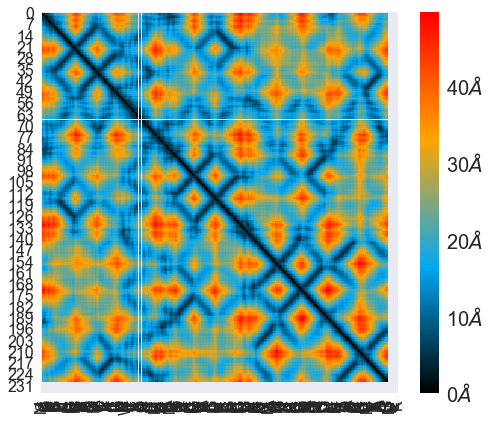

In [387]:
dist = cdist(ca_coordinate[:, 1:4], ca_coordinate[:, 1:4])
print(sequence_short)

%matplotlib inline

plt.figure(figsize=(8,7))
ax = sns.heatmap(dist, cmap=cmap, xticklabels=sequence_short, cbar_kws={'format': '%.0f$\AA$'})
plt.tick_params(labelsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
# plt.savefig(f'/home/data/risa/')
plt.show()


### 3次元上に座標をplot
- 最初と最後と, 発色団(65, 67番)の計10個のアミノ酸は抜けている

In [352]:
#　座標が存在しない(nan)アミノ酸を除く
ca_coordinate_del = ca_coordinate[~np.isnan(ca_coordinate).any(axis=1)]
print(len(ca_coordinate_del))

226


In [353]:
x_coordinate = ca_coordinate[:, 1]
y_coordinate = ca_coordinate[:, 2]
z_coordinate = ca_coordinate[:, 3]

<IPython.core.display.Javascript object>


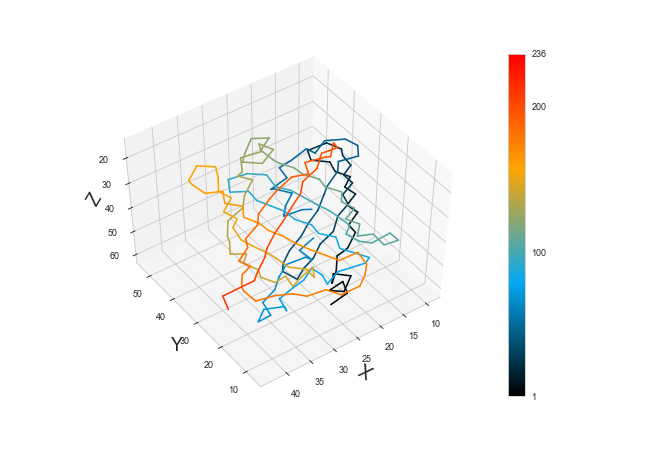

In [382]:
%matplotlib notebook
# %matplotlib inline

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')

point = np.arange(1, len(x_coordinate)+1)
dummie_cax = ax.scatter(point, point, c=point, cmap=cmap)
ax.cla()

for i in range(len(x_coordinate)-1):
    ax.plot(x_coordinate[i:i+2], y_coordinate[i:i+2], z_coordinate[i:i+2], c=cmap(i))    


ax.set_xlabel('X', fontsize=20, rotation=150)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20, rotation=60)
ax.yaxis._axinfo['label']['space_factor'] = 3.0

fig.colorbar(dummie_cax, ticks=[1, 100, 200, len(x_coordinate)])


### contact mapを求める

In [383]:
def get_cm(dist, thres):
    contact_map = np.where(dist < thres, 1, 0)
    
    # 正確には, 上下反転で可視化することが多いかも?
    print(contact_map)
    
    
    plt.figure(figsize=(8,7))
    ax = sns.heatmap(contact_map, xticklabels=sequence_short)
    plt.tick_params(labelsize=16)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    # plt.savefig(f'/home/data/risa/')
    plt.show()


/home/lab/igarashi/.pyenv/versions/anaconda3-4.3.1/envs/mac/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


[[0 0 0 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


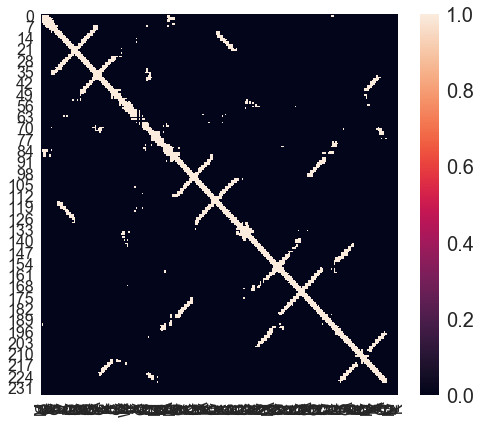

In [388]:
%matplotlib inline

get_cm(dist, 8)


In [341]:
pd.DataFrame(atom_coordinate)

,0,1,2,3,4,5,6,7,8,9,10
0,1,N,SER,A,2,28.888,9.409,52.301,1.00,85.05,N
1,2,CA,SER,A,2,27.638,10.125,52.516,1.00,80.05,C
2,3,C,SER,A,2,26.499,9.639,51.644,1.00,85.36,C
3,4,O,SER,A,2,26.606,8.656,50.915,1.00,84.56,O
4,5,CB,SER,A,2,27.783,11.635,52.378,1.00,70.97,C
5,6,OG,SER,A,2,27.690,12.033,51.012,1.00,44.08,O
6,7,N,LYS,A,3,25.418,10.403,51.731,1.00,87.71,N
7,8,CA,LYS,A,3,24.141,10.191,51.036,1.00,87.15,C
8,9,C,LYS,A,3,24.214,10.266,49.497,1.00,76.86,C
9,10,O,LYS,A,3,24.107,9.258,48.774,1.00,78.27,O
